In [ ]:
# Instalación de Keras Tuner
!pip install keras-tuner --upgrade

# Instalación de Tslearn
!pip install tslearn

In [ ]:
# Importando las librerías
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.utils import plot_model
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# permite mostrar los gráficos de matplotlib dentro del cuaderno jupyter
%matplotlib inline

In [ ]:
TARGET = "Symptoms_bef_Dg_DIC_wo_vagal" # variable objetivo o etiqueta a predecir
patient_id = "BH" # ID del paciente

raw_time_series = pd.read_excel("./Biomarkers_12leads.xlsx") #Lectura de los datos de ECG
raw_time_series.fillna(0, inplace=True) #Reemplazar los valores faltantes del dataset de ECG por ceros

raw_labels_df = pd.read_excel("./dsBiomarkersPlusClinical.xlsx")[[patient_id, TARGET]] #Lectura del dataset que contiene el ID del paciente y la etiqueta

In [ ]:
labels_df = raw_labels_df.groupby(patient_id, as_index=False).agg(TARGET).first() #Agrupando el dataset por ID de paciente y agregando la etiqueta
time_series = raw_time_series.join(labels_df.set_index(patient_id), on=patient_id) #Uniendo el dataset de variables de ECG con la etiqueta correspondiente mediante el ID del paciente

time_series=time_series[~time_series[TARGET].isna()] #Filtrando los pacientes que no tienen una etiqueta

In [ ]:
#Extrayendo las entradas y etiquetas (salidas esperadas)
X = time_series.drop(columns=[TARGET]) #Variables de entrada con el ID del paciente
y = time_series[[patient_id, TARGET]] #Etiquetas con el ID del paciente

In [ ]:
features = X.columns.tolist() #Creando una lista de las variables de entrada
features.remove(patient_id) #Eliminando el ID del paciente de la lista

In [ ]:
X_series = [] #Definiendo una lista para las series temporales de entrada
y_series = [] #Definiendo una lista para las etiquetas

for id, group in X.groupby(patient_id): #Iterando por cada uno de los pacientes (agrupando las entradas por el ID del paciente)
  feature_ts = group[features] #Guardando todas las variables (series temporales) del paciente

  # Proceso de padding para tener la misma longitud de series temporales para todos los pacientes (478 observaciones por cada serie), agregando ceros al final
  num_rows_to_add = 478 - len(feature_ts) #Cálculo del número de filas para agregar al final
  zeros_to_add = [[0] * len(feature_ts.columns)] * num_rows_to_add #Cálculo del número de ceros que se debe agregar al final
  feature_ts = pd.concat([feature_ts, pd.DataFrame(zeros_to_add, columns=feature_ts.columns)], ignore_index=True) #Concatenando los ceros calculados al final de las series temporales del paciente

  label = y[y[patient_id] == id].iloc[0][TARGET] #Guardando la salida esperada del paciente, al usar iloc[0][TARGET] se obtiene el primer valor de las etiquetas de ese paciente (todas las etiquetas del paciente son el mismo valor)

  X_series.append(np.array(feature_ts)) #Agregando las series temporales del paciente a la lista definida anteriormente
  y_series.append(np.array(label)) #Agregando la etiqueta del paciente a la lista

In [ ]:
len(X_series), len(y_series) #Comprobando que se tiene el mismo número de entradas y de etiquetas

(64, 64)

In [ ]:
#Dividiendo las entradas y salidas en datasets de entrenamiento y prueba, con una proporción de 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, random_state=1) #La función train_test_split permite tener una distribución de pacientes similar en los sets de entrenamiento y prueba

# Transformando las listas de entrenamiento y prueba en arrays de 3 dimensiones
X_train = np.dstack(X_train).transpose()
X_test = np.dstack(X_test).transpose()
y_train = np.dstack(y_train).transpose()
y_test = np.dstack(y_test).transpose()

# Definiendo el escalador de series temporales (Mean Variance)
scaler = TimeSeriesScalerMeanVariance()

# Escalando datos de entrenamiento y pruebas
X_trains = scaler.fit_transform(X_train)
X_tests = scaler.transform(X_test)

In [ ]:
X_test.shape #Comprobando la forma de los arrays de 3 dimensiones

(13, 132, 478)

In [ ]:
X_train.shape #Comprobando la forma de los arrays de 3 dimensiones

(51, 132, 478)

In [ ]:
def build_model(hp): #Función para construir el modelo en Keras Tuner
  model = keras.Sequential() #Creando el objeto de la clase Sequential que será la red neuronal secuencial

  #Agregando la capa de entrada con la función Flatten, que aplana todas las variables del paciente (132 variables y 478 observaciones) a una dimensión
  model.add(keras.layers.Flatten(input_shape=(132, 478)))

  # Afinando el número de neuronas en la capa oculta, encontrando el valor óptimo entre 32-512
  hp_units = hp.Int('units', min_value=32,
                    max_value=512, step=32)

  dropout_rate = hp.Choice(name='dropout_rate',values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

  model.add(tf.keras.layers.Dropout(dropout_rate)) #de 0 a 1

  #Agregando la capa oculta densa con el número de neuronas óptimo
  model.add(keras.layers.Dense(units=hp_units,
      activation='relu'))

  model.add(tf.keras.layers.Dropout(dropout_rate)) #de 0 a 1

  #Agregando la capa de salida con 2 neuronas, una para cada categoría (sintomático o asintomático)
  model.add(keras.layers.Dense(2, activation='sigmoid')) # Output layer with 2 classes (0 and 1)

  #Afinando el learning rate con el valor óptimo entre 1e-2, 1e-3 y 1e-4
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #Compilando el modelo con los valores óptimos encontrados
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
#Creando el objeto de la clase Keras Tuner Hyperband que utilice la función creada anteriormente y afine los mojores valores para la red
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
#Creando el objeto de la clase EarlyStopping para detener el entrenamiento cuando la métrica de val_loss deje de mejorar
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss',
    patience=0
)

In [ ]:
#Ejecutando el tuner
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks = [stop_early])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] #Obteniendo los mejores hiperparámetros del tuner

print(f"""
Numero óptimo de unidades en la capa oculta: {best_hps.get('units')} . Learning rate óptimo: {best_hps.get('learning_rate')}.
""")


Numero óptimo de unidades en la capa oculta: 352 . Learning rate óptimo: 0.001.



In [ ]:
model = tuner.hypermodel.build(best_hps) #Creando el modelo con los hiperparámetros óptimos
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2) #Entrenando el modelo y guardando el historial del entrenamiento

val_acc_per_epoch = history.history['val_accuracy'] #Guardando el historial de la métrica accuracy en todo el entrenamiento
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1 #Obteniendo la iteración del entrenamiento en donde se tuvo la mejor métrica de accuracy
print('Best epoch: %d' % (best_epoch,)) #Mostrando la mejor iteración

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 3s 1s/step - loss: 955.5809 - accuracy: 0.5250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - 1s 550ms/step - loss: 497.2807 - accuracy: 0.8250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - 1s 395ms/step - loss: 960.1885 - accuracy: 0.7750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 1s 371ms/step - loss: 774.5322 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 1s 434ms/step - loss: 793.3963 - accuracy: 0.8500 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
2/2 [==============================] - 1s 407ms/step - loss: 844.8763 - accuracy: 0.7750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
2/2 [==============================] - 1s 404ms/step - loss: 577.4518 - accuracy: 0.7250 - val_loss: 0.0000e+00 - val_accuracy:

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Entrenando el modelo de nuevo con el mejor número de iteración
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.3)

2/2 [==============================] - 2s 558ms/step - loss: 1312.9639 - accuracy: 0.4571 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 0s 45ms/step - loss: 662.5241 - accuracy: 0.7692
[test loss, test accuracy]: [662.5241088867188, 0.7692307829856873]


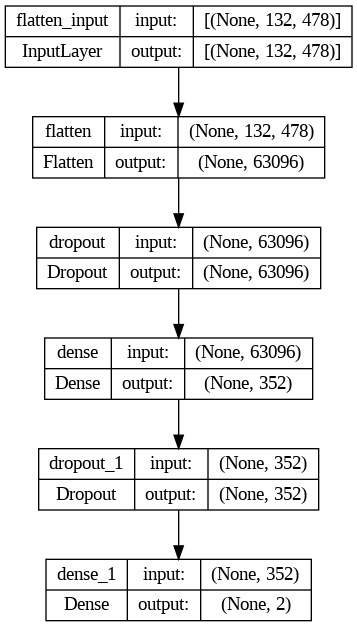

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

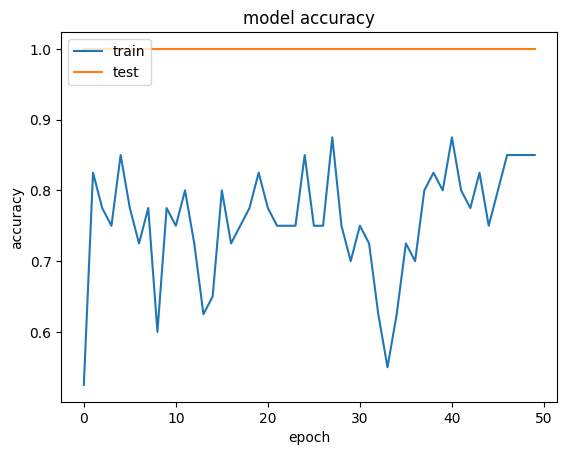

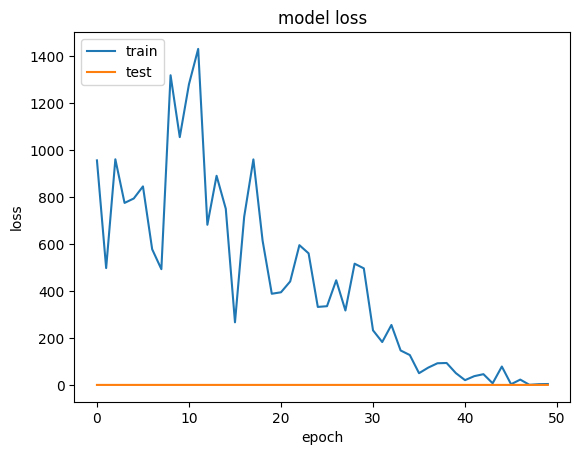

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 128ms/step


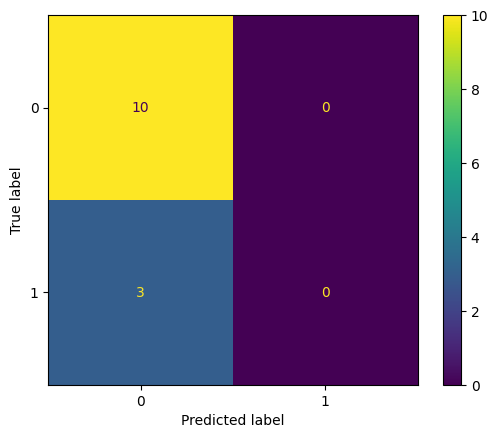

Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Accuracy: 0.769


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions = model.predict(X_test)
prediction_classes = predictions.argmax(axis=-1)

cm = confusion_matrix(y_test.flatten(), prediction_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


print('Precision: %.3f' % precision_score(y_test.flatten(), prediction_classes))
print('Recall: %.3f' % recall_score(y_test.flatten(), prediction_classes))
print('F1 Score: %.3f' % f1_score(y_test.flatten(), prediction_classes))

print('Accuracy: %.3f' % accuracy_score(y_test.flatten(), prediction_classes))

In [ ]:
model.save('all_var.keras')